# Feature Selection: Correlation & Multicollinearity Analysis
## Loan Default Prediction Project

This notebook performs comprehensive feature selection through:
1. **Correlation Analysis** - Remove highly correlated features
2. **Target Correlation** - Identify features with low predictive power
3. **Multicollinearity (VIF)** - Detect and handle multicollinear features
4. **Mutual Information** - Measure non-linear relationships

---

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## Step 1: Load Processed Data

In [2]:
# Load the processed data
X = pd.read_csv('processed_data/X_processed.csv')
y = pd.read_csv('processed_data/y_target.csv').squeeze()

print(f"✓ Features loaded: {X.shape}")
print(f"✓ Target loaded: {y.shape}")
print(f"✓ Default rate: {y.mean():.2%}")

# Display first few rows
X.head()

✓ Features loaded: (121856, 47)
✓ Target loaded: (121856,)
✓ Default rate: 8.08%


,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Has_House_Age_Info,Score_Source_1_Available,Score_Source_2_Available,Score_Source_3_Available,Num_Credit_Scores_Available,Has_Credit_Bureau_Record,Social_Circle_Data_Available,Has_Employment_History,Occupation_Disclosed
0,6750.0,0,0,1,0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,-13957.0,-1062.0,-6123.0,-383.0,0.0,1,1,0,Sales,2.0,2.0,6.0,17.0,1,1,Self-employed,0.568066,0.478787,0.000000,0.0186,63.0,0.0,0,1,1,0,2,0,1,1,1
1,20250.0,1,0,1,0,0.0,15282.00,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,-14162.0,-4129.0,-7833.0,-21.0,0.0,1,0,1,Not_Disclosed,2.0,2.0,3.0,10.0,1,1,Government,0.563360,0.215068,0.000000,0.0000,755.0,0.0,0,1,1,0,2,0,0,1,0
2,18000.0,0,0,1,0,1.0,59527.35,2788.20,Alone,Service,Graduation dropout,W,Male,CL,Family,0.022800,-16790.0,-5102.0,-4493.0,-331.0,0.0,1,0,0,Realty agents,2.0,2.0,4.0,12.0,1,1,Self-employed,0.000000,0.552795,0.329655,0.0742,277.0,0.0,0,0,1,1,2,0,1,1,1
3,15750.0,0,0,1,1,0.0,53870.40,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,-23195.0,-1649.0,-4493.0,-775.0,9.0,1,0,0,Not_Disclosed,2.0,3.0,2.0,15.0,1,1,Not_Disclosed,0.000000,0.135182,0.631355,0.0000,1700.0,3.0,1,0,1,1,2,1,0,1,0
4,33750.0,1,0,1,0,2.0,133988.40,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,-11366.0,-2977.0,-5516.0,-4043.0,6.0,1,0,0,Laborers,4.0,1.0,3.0,12.0,1,1,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,1,1,1,1,3,1,1,1,1


## Step 2: Feature Overview & Basic Checks

In [3]:
# Separate features by type
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"📊 Feature Types:")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features: {len(categorical_features)}")
print(f"  - Total features: {X.shape[1]}")

print("\n📋 Categorical features:")
for i, feat in enumerate(categorical_features, 1):
    print(f"  {i}. {feat}")

📊 Feature Types:
  - Numeric features: 38
  - Categorical features: 9
  - Total features: 47

📋 Categorical features:
  1. Accompany_Client
  2. Client_Income_Type
  3. Client_Education
  4. Client_Marital_Status
  5. Client_Gender
  6. Loan_Contract_Type
  7. Client_Housing_Type
  8. Client_Occupation
  9. Type_Organization


In [4]:
# Check for constant features (only one unique value)
constant_features = []
for col in X.columns:
    if X[col].nunique() <= 1:
        constant_features.append(col)

if constant_features:
    print(f"⚠️  Found {len(constant_features)} constant features to remove:")
    for feat in constant_features:
        print(f"    - {feat}")
    X = X.drop(columns=constant_features)
    numeric_features = [f for f in numeric_features if f not in constant_features]
else:
    print("✓ No constant features found")

✓ No constant features found


## Step 3: Correlation Analysis Between Features

We'll identify pairs of features with high correlation (|r| > 0.8) as they provide redundant information.

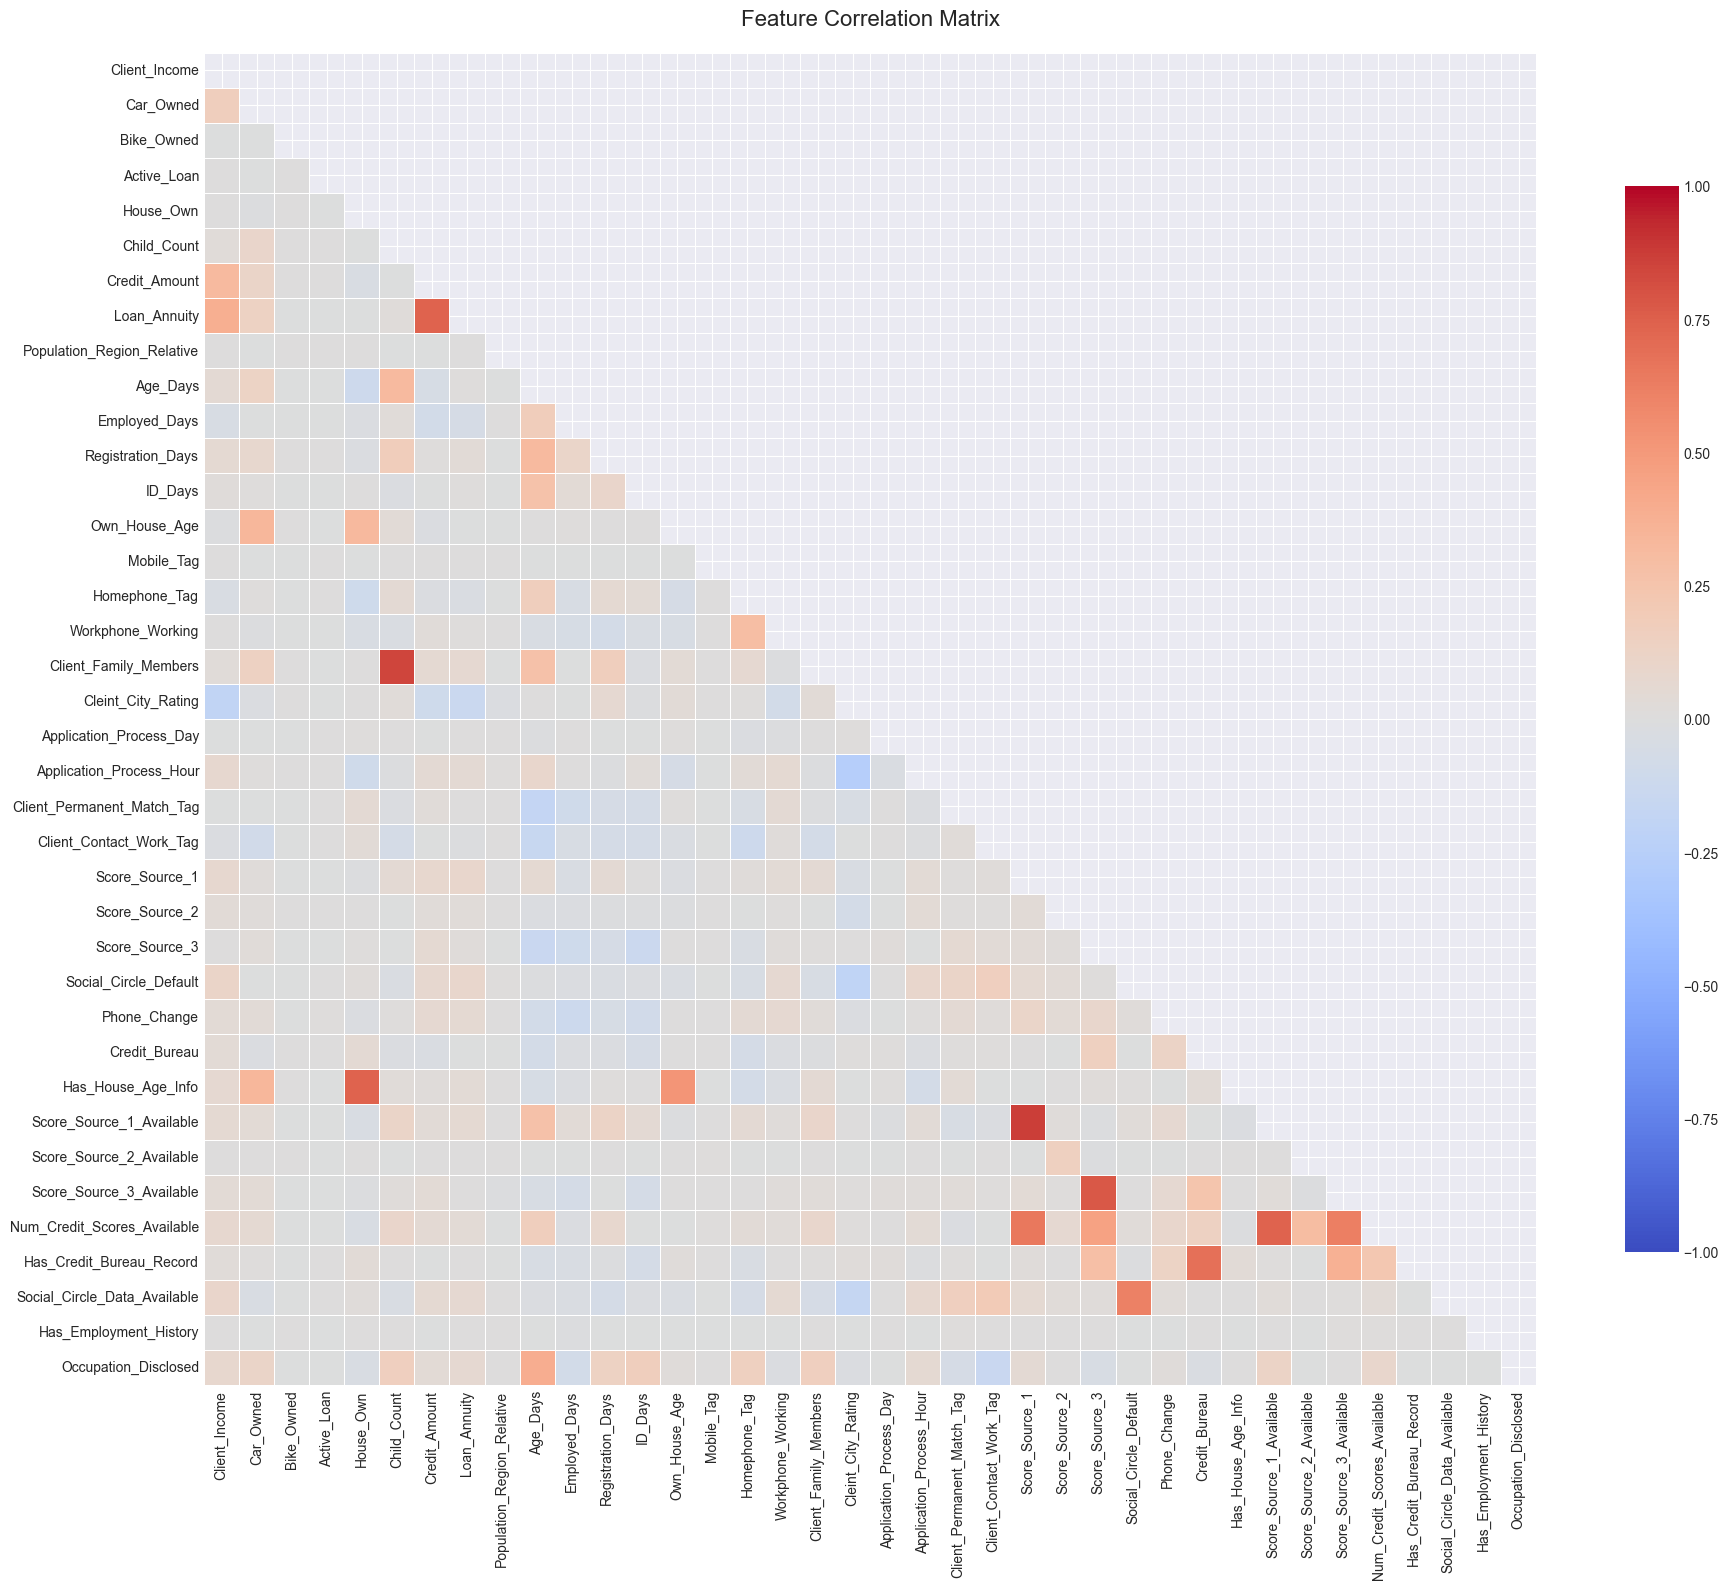

In [5]:
# Calculate correlation matrix for numeric features
numeric_data = X[numeric_features]
corr_matrix = numeric_data.corr()

# Visualize correlation matrix
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot=False)
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

In [6]:
# Find highly correlated feature pairs
def find_high_correlations(corr_matrix, threshold=0.8):
    """Find feature pairs with correlation above threshold"""
    high_corr_pairs = []
    
    # Get upper triangle of correlation matrix
    upper_triangle = np.triu(corr_matrix, k=1)
    
    # Find indices where correlation > threshold
    high_corr_indices = np.where(np.abs(upper_triangle) > threshold)
    
    # Get feature names for high correlations
    for i, j in zip(high_corr_indices[0], high_corr_indices[1]):
        feature1 = corr_matrix.columns[i]
        feature2 = corr_matrix.columns[j]
        correlation = corr_matrix.iloc[i, j]
        high_corr_pairs.append({
            'Feature_1': feature1,
            'Feature_2': feature2,
            'Correlation': correlation
        })
    
    return pd.DataFrame(high_corr_pairs).sort_values('Correlation', 
                                                     ascending=False, 
                                                     key=abs)

# Find high correlations
high_corr_df = find_high_correlations(corr_matrix, threshold=0.8)

if len(high_corr_df) > 0:
    print(f"⚠️  Found {len(high_corr_df)} highly correlated feature pairs (|r| > 0.8):")
    display(high_corr_df)
else:
    print("✓ No highly correlated feature pairs found (|r| > 0.8)")

⚠️  Found 2 highly correlated feature pairs (|r| > 0.8):


,Feature_1,Feature_2,Correlation
1,Score_Source_1,Score_Source_1_Available,0.872262
0,Child_Count,Client_Family_Members,0.850233


## Step 4: Target Correlation Analysis

Identify features with low correlation to the target variable (Default).

In [7]:
# Calculate correlation with target
target_corr = numeric_data.corrwith(y).abs().sort_values(ascending=False)

print("📊 Top 20 Features Correlated with Default:")
for i, (feature, corr) in enumerate(target_corr.head(20).items(), 1):
    print(f"{i:2d}. {feature:35s} |r| = {corr:.4f}")

📊 Top 20 Features Correlated with Default:
 1. Score_Source_3                      |r| = 0.1081
 2. Age_Days                            |r| = 0.0730
 3. Score_Source_1                      |r| = 0.0651
 4. Employed_Days                       |r| = 0.0631
 5. Cleint_City_Rating                  |r| = 0.0583
 6. Phone_Change                        |r| = 0.0538
 7. ID_Days                             |r| = 0.0527
 8. Client_Permanent_Match_Tag          |r| = 0.0425
 9. Social_Circle_Default               |r| = 0.0416
10. Social_Circle_Data_Available        |r| = 0.0404
11. Registration_Days                   |r| = 0.0379
12. Score_Source_2                      |r| = 0.0363
13. Occupation_Disclosed                |r| = 0.0352
14. Credit_Amount                       |r| = 0.0305
15. Client_Contact_Work_Tag             |r| = 0.0280
16. Workphone_Working                   |r| = 0.0257
17. Num_Credit_Scores_Available         |r| = 0.0246
18. Application_Process_Hour            |r| = 0.0232
19.

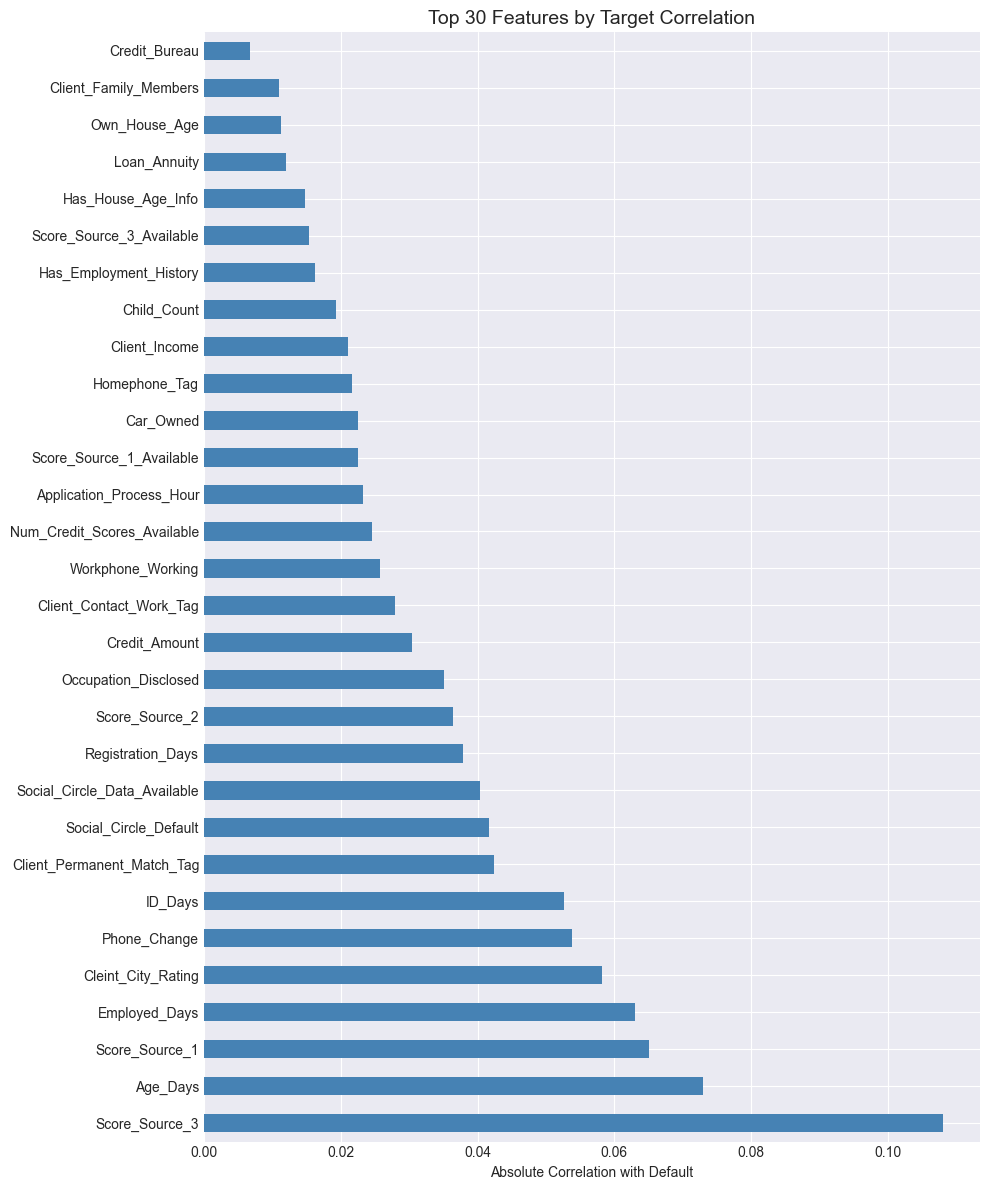

In [8]:
# Visualize target correlations
plt.figure(figsize=(10, 12))
target_corr.head(30).plot(kind='barh', color='steelblue')
plt.xlabel('Absolute Correlation with Default')
plt.title('Top 30 Features by Target Correlation', fontsize=14)
plt.tight_layout()
plt.show()

In [16]:
# Identify low correlation features
low_corr_threshold = 0.01  # 0.001
low_corr_features = target_corr[target_corr < low_corr_threshold].index.tolist()

if low_corr_features:
    print(f"⚠️  Found {len(low_corr_features)} features with very low target correlation (|r| < {low_corr_threshold}):")
    for feat in low_corr_features[:10]:  # Show first 10
        print(f"    - {feat}: |r| = {target_corr[feat]:.4f}")
    if len(low_corr_features) > 10:
        print(f"    ... and {len(low_corr_features) - 10} more")

⚠️  Found 3 features with very low target correlation (|r| < 0.001):
    - Mobile_Tag: |r| = 0.0008
    - Bike_Owned: |r| = 0.0004
    - Active_Loan: |r| = 0.0001


## Step 5: Multicollinearity Analysis (VIF)

Variance Inflation Factor (VIF) measures how much the variance of a coefficient increases due to collinearity.
- VIF = 1: No correlation
- VIF > 5: Moderate multicollinearity
- VIF > 10: High multicollinearity (problematic)

In [10]:
# Prepare data for VIF calculation
numeric_data_clean = numeric_data.fillna(0)
numeric_data_clean = numeric_data_clean.replace([np.inf, -np.inf], 0)

print("⏳ Calculating VIF (this may take a minute)...")

# Calculate VIF for all numeric features
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_data_clean.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_data_clean.values, i) 
                   for i in range(len(numeric_data_clean.columns))]
vif_df = vif_data.sort_values('VIF', ascending=False)

# Display high VIF features
high_vif = vif_df[vif_df['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n⚠️  Features with HIGH multicollinearity (VIF > 10):")
    display(high_vif)

moderate_vif = vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)]
if len(moderate_vif) > 0:
    print(f"\n⚠️  Features with MODERATE multicollinearity (VIF > 5):")
    display(moderate_vif.head(10))

⏳ Calculating VIF (this may take a minute)...

⚠️  Features with HIGH multicollinearity (VIF > 10):


,Feature,VIF
31,Score_Source_2_Available,inf
30,Score_Source_1_Available,inf
33,Num_Credit_Scores_Available,inf
32,Score_Source_3_Available,inf
14,Mobile_Tag,1.366197e+04
36,Has_Employment_History,1.354772e+04
9,Age_Days,2.783673e+01
17,Client_Family_Members,2.499393e+01
18,Cleint_City_Rating,2.044902e+01
20,Application_Process_Hour,1.646637e+01



⚠️  Features with MODERATE multicollinearity (VIF > 5):


,Feature,VIF
25,Score_Source_3,8.442929
4,House_Own,8.150036
23,Score_Source_1,7.876951
6,Credit_Amount,7.441018
22,Client_Contact_Work_Tag,6.108555
12,ID_Days,5.727907
34,Has_Credit_Bureau_Record,5.403286


## Step 6: Mutual Information Analysis

Mutual Information captures non-linear relationships between features and target.

In [11]:
# Calculate mutual information
print("⏳ Calculating mutual information scores...")

mi_scores = mutual_info_classif(numeric_data_clean, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': numeric_features,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\n📊 Top 20 Features by Mutual Information:")
display(mi_df.head(20))

# Features with zero mutual information
zero_mi = mi_df[mi_df['MI_Score'] == 0]['Feature'].tolist()
if zero_mi:
    print(f"\n⚠️  Found {len(zero_mi)} features with zero mutual information")

⏳ Calculating mutual information scores...

📊 Top 20 Features by Mutual Information:


,Feature,MI_Score
31,Score_Source_2_Available,0.028846
14,Mobile_Tag,0.025206
32,Score_Source_3_Available,0.022900
24,Score_Source_2,0.022500
37,Occupation_Disclosed,0.022116
29,Has_House_Age_Info,0.022080
22,Client_Contact_Work_Tag,0.021942
34,Has_Credit_Bureau_Record,0.021448
18,Cleint_City_Rating,0.021353
4,House_Own,0.019874


## Step 7: Feature Selection Decisions

Based on our analysis, we'll decide which features to remove.

In [12]:
# Collect features to remove
features_to_remove = set()
removal_reasons = {}

# 1. Handle highly correlated pairs
if len(high_corr_df) > 0:
    print("1️⃣ Handling Highly Correlated Pairs:")
    for _, row in high_corr_df.iterrows():
        feat1, feat2 = row['Feature_1'], row['Feature_2']
        corr1 = abs(target_corr.get(feat1, 0))
        corr2 = abs(target_corr.get(feat2, 0))
        
        # Remove the feature with lower target correlation
        if corr1 > corr2:
            features_to_remove.add(feat2)
            removal_reasons[feat2] = f"High correlation with {feat1} (r={row['Correlation']:.3f})"
            print(f"   - Remove '{feat2}' (keep '{feat1}')")
        else:
            features_to_remove.add(feat1)
            removal_reasons[feat1] = f"High correlation with {feat2} (r={row['Correlation']:.3f})"
            print(f"   - Remove '{feat1}' (keep '{feat2}')")

# 2. Features with both low correlation and low MI
if len(low_corr_features) > 0:
    low_mi_features = mi_df[mi_df['MI_Score'] < 0.01]['Feature'].tolist()
    low_importance_features = set(low_corr_features) & set(low_mi_features)
    
    if low_importance_features:
        print(f"\n2️⃣ Low Importance Features (low correlation AND low MI):")
        for feat in list(low_importance_features)[:5]:
            features_to_remove.add(feat)
            removal_reasons[feat] = "Low correlation and mutual information"
            print(f"   - Remove '{feat}'")

print(f"\n📋 SUMMARY:")
print(f"   - Total features: {X.shape[1]}")
print(f"   - Features to remove: {len(features_to_remove)}")
print(f"   - Features to keep: {X.shape[1] - len(features_to_remove)}")

1️⃣ Handling Highly Correlated Pairs:
   - Remove 'Score_Source_1_Available' (keep 'Score_Source_1')
   - Remove 'Client_Family_Members' (keep 'Child_Count')

2️⃣ Low Importance Features (low correlation AND low MI):
   - Remove 'Application_Process_Day'
   - Remove 'Population_Region_Relative'
   - Remove 'Bike_Owned'
   - Remove 'Credit_Bureau'

📋 SUMMARY:
   - Total features: 47
   - Features to remove: 6
   - Features to keep: 41


## Step 8: Create Final Feature Set

In [13]:
# Create final feature list
features_to_keep = [col for col in X.columns if col not in features_to_remove]

# Create cleaned dataset
X_selected = X[features_to_keep].copy()

print(f"✓ Original features: {X.shape[1]}")
print(f"✓ Selected features: {X_selected.shape[1]}")
print(f"✓ Features removed: {len(features_to_remove)}")
print(f"✓ Reduction: {(len(features_to_remove)/X.shape[1])*100:.1f}%")

# Save selected features
X_selected.to_csv('processed_data/X_selected.csv', index=False)
print(f"\n✓ Selected features saved to: processed_data/X_selected.csv")

✓ Original features: 47
✓ Selected features: 41
✓ Features removed: 6
✓ Reduction: 12.8%

✓ Selected features saved to: processed_data/X_selected.csv


In [14]:
# Display removed features summary
if features_to_remove:
    removal_df = pd.DataFrame([
        {'Feature': feat, 'Reason': removal_reasons.get(feat, 'Unknown')}
        for feat in sorted(features_to_remove)
    ])
    print("\n📋 Features Removed:")
    display(removal_df)


📋 Features Removed:


,Feature,Reason
0,Application_Process_Day,Low correlation and mutual information
1,Bike_Owned,Low correlation and mutual information
2,Client_Family_Members,High correlation with Child_Count (r=0.850)
3,Credit_Bureau,Low correlation and mutual information
4,Population_Region_Relative,Low correlation and mutual information
5,Score_Source_1_Available,High correlation with Score_Source_1 (r=0.872)


In [15]:
# Final feature summary
selected_numeric = [f for f in features_to_keep if f in numeric_features]
selected_categorical = [f for f in features_to_keep if f in categorical_features]

print("\n🎯 FINAL FEATURE SET:")
print(f"\nNumeric features ({len(selected_numeric)}):")
for i, feat in enumerate(selected_numeric[:10], 1):
    print(f"  {i:2d}. {feat}")
if len(selected_numeric) > 10:
    print(f"  ... and {len(selected_numeric) - 10} more")

print(f"\nCategorical features ({len(selected_categorical)}):")
for i, feat in enumerate(selected_categorical, 1):
    print(f"  {i:2d}. {feat}")


🎯 FINAL FEATURE SET:

Numeric features (32):
   1. Client_Income
   2. Car_Owned
   3. Active_Loan
   4. House_Own
   5. Child_Count
   6. Credit_Amount
   7. Loan_Annuity
   8. Age_Days
   9. Employed_Days
  10. Registration_Days
  ... and 22 more

Categorical features (9):
   1. Accompany_Client
   2. Client_Income_Type
   3. Client_Education
   4. Client_Marital_Status
   5. Client_Gender
   6. Loan_Contract_Type
   7. Client_Housing_Type
   8. Client_Occupation
   9. Type_Organization


## Summary & Next Steps

### What we accomplished:
1. ✅ Identified and handled correlated feature pairs
2. ✅ Detected multicollinear features using VIF
3. ✅ Found low-importance features using correlation and MI
4. ✅ Created optimized feature set

### Next steps:
1. **Train/Test Split** - Split data before encoding
2. **Encoding** - Apply appropriate encoding to categorical variables
3. **Scaling** - Normalize numeric features if needed
4. **Model Training** - Train various models with selected features

### Files created:
- `processed_data/X_selected.csv` - Final feature set
- `feature_correlation_matrix.png` - Correlation heatmap
- `target_correlation_top30.png` - Target correlation plot
- `vif_analysis.csv` - VIF scores for all features